# Exploratory Data Analysis: GSE68379 - Cancer Cell Line Pharmacoepigenomics

## Dataset Overview

**GEO Accession**: GSE68379

**Title**: The landscape of pharmacogenomic interactions in human cancer

**Description**: 
- 721 cancer cell lines across 22 cancer types
- DNA methylation profiled using Infinium HumanMethylation450K BeadChip
- Associated with drug response data from GDSC (Genomics of Drug Sensitivity in Cancer)
- Focus on identifying epigenetic biomarkers of drug sensitivity

**Reference**: Ohnmacht et al. (2023) - Pharmacoepigenetics in human cancer

---

## Analysis Objectives

1. Load and validate methylation data
2. Explore methylation patterns across cancer types
3. Perform dimensionality reduction (PCA) to identify major sources of variation
4. Investigate clustering patterns by cancer type and primary site
5. Identify potential batch effects or technical artifacts

## 1. Setup and Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Define directories
data_dir = Path('../data')
raw_dir = data_dir / 'raw' / 'GSE68379'
processed_dir = data_dir / 'processed'
figures_dir = data_dir / 'figures'
figures_dir.mkdir(parents=True, exist_ok=True)

print('Environment setup complete')
print(f'Data directory: {data_dir.resolve()}')
print(f'Figures will be saved to: {figures_dir.resolve()}')

Environment setup complete
Data directory: C:\Users\joon4\OneDrive\Documents\GitHub\bioml_working_repo\data
Figures will be saved to: C:\Users\joon4\OneDrive\Documents\GitHub\bioml_working_repo\data\figures


## 2. Load Data

In [18]:
# Load processed methylation matrix
print('Loading GSE68379 methylation data...')
meth_file = raw_dir / 'GSE68379_Matrix.processed.txt.gz'

# Read methylation data
# Column 0: Row numbers, Column 1: CpG IDs, rest are cell lines
df_methylation_full = pd.read_csv(meth_file, sep='\t', index_col=1, compression='gzip')

# Drop Row.names column if present
if 'Row.names' in df_methylation_full.columns:
    df_methylation_full = df_methylation_full.drop('Row.names', axis=1)

# Clean column names - remove _AVG.Beta suffix
df_methylation_full.columns = [col.replace('_AVG.Beta', '') for col in df_methylation_full.columns]

print(f'Full matrix shape: {df_methylation_full.shape}')
print(f'  CpG sites: {df_methylation_full.shape[0]:,}')
print(f'  Total samples: {df_methylation_full.shape[1]:,}')

Loading GSE68379 methylation data...
Full matrix shape: (485512, 2056)
  CpG sites: 485,512
  Total samples: 2,056


In [19]:
# Load sample metadata
print('\nLoading sample metadata...')
df_metadata = pd.read_csv(processed_dir / 'GSE68379_sample_metadata.csv')

# Set cell line name as index for easy mapping
df_metadata = df_metadata.set_index('source_name')

print(f'Metadata shape: {df_metadata.shape}')
print(f'  Samples with metadata: {len(df_metadata)}')
print(f'\nMetadata columns: {list(df_metadata.columns)}')
print(f'\nFirst few rows:')
df_metadata.head()


Loading sample metadata...
Metadata shape: (1028, 6)
  Samples with metadata: 1028

Metadata columns: ['gsm_id', 'cell line', 'primary site', 'primary histology', 'cosmic_id', 'title']

First few rows:


gsm_id cell line       primary site  \
source_name                                            
697          GSM1669562       697              blood   
5637         GSM1669563      5637  urogenital_system   
201T         GSM1669564      201T               lung   
22RV1        GSM1669565     22RV1  urogenital_system   
23132-87     GSM1669566  23132-87   digestive_system   

                     primary histology  cosmic_id              title  
source_name                                                           
697             lymphoblastic_leukemia   906800.0       CellLine_697  
5637                           bladder   687452.0      CellLine_5637  
201T         lung_NSCLC_adenocarcinoma  1287381.0      CellLine_201T  
22RV1                         prostate   924100.0     CellLine_22RV1  
23132-87                       stomach   910924.0  CellLine_23132-87

In [20]:
# Filter methylation matrix to only include samples with metadata
common_samples = list(set(df_metadata.index) & set(df_methylation_full.columns))
df_methylation = df_methylation_full[common_samples].copy()

print(f'\nFiltered to samples with metadata:')
print(f'  CpG sites: {df_methylation.shape[0]:,}')
print(f'  Cell lines: {df_methylation.shape[1]:,}')
print(f'  Samples with metadata: {len(common_samples)}')


Filtered to samples with metadata:
  CpG sites: 485,512
  Cell lines: 1,028
  Samples with metadata: 1028


## 3. Data Quality Checks

In [21]:
# Check for missing values
missing_cpgs = df_methylation.isnull().sum(axis=1)
missing_samples = df_methylation.isnull().sum(axis=0)

print('Missing Value Analysis:')
print(f'  CpG sites with any missing values: {(missing_cpgs > 0).sum():,} ({100 * (missing_cpgs > 0).sum() / len(missing_cpgs):.2f}%)')
print(f'  Samples with any missing values: {(missing_samples > 0).sum():,} ({100 * (missing_samples > 0).sum() / len(missing_samples):.2f}%)')
print(f'  Total missing values: {df_methylation.isnull().sum().sum():,}')

# Beta-value validation
min_val = df_methylation.min().min()
max_val = df_methylation.max().max()
mean_val = df_methylation.mean().mean()
median_val = df_methylation.median().median()

print(f'\nBeta-value Statistics:')
print(f'  Range: [{min_val:.6f}, {max_val:.6f}]')
print(f'  Mean: {mean_val:.6f}')
print(f'  Median: {median_val:.6f}')

if min_val >= 0 and max_val <= 1:
    print('  [OK] Beta-values are within valid [0, 1] range')
else:
    print('  [WARNING] Some beta-values are outside [0, 1] range!')

Missing Value Analysis:
  CpG sites with any missing values: 10,995 (2.26%)
  Samples with any missing values: 1,026 (99.81%)
  Total missing values: 47,307

Beta-value Statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.506015
  Median: 0.566185
  [OK] Beta-values are within valid [0, 1] range


## 4. Methylation Distribution Analysis

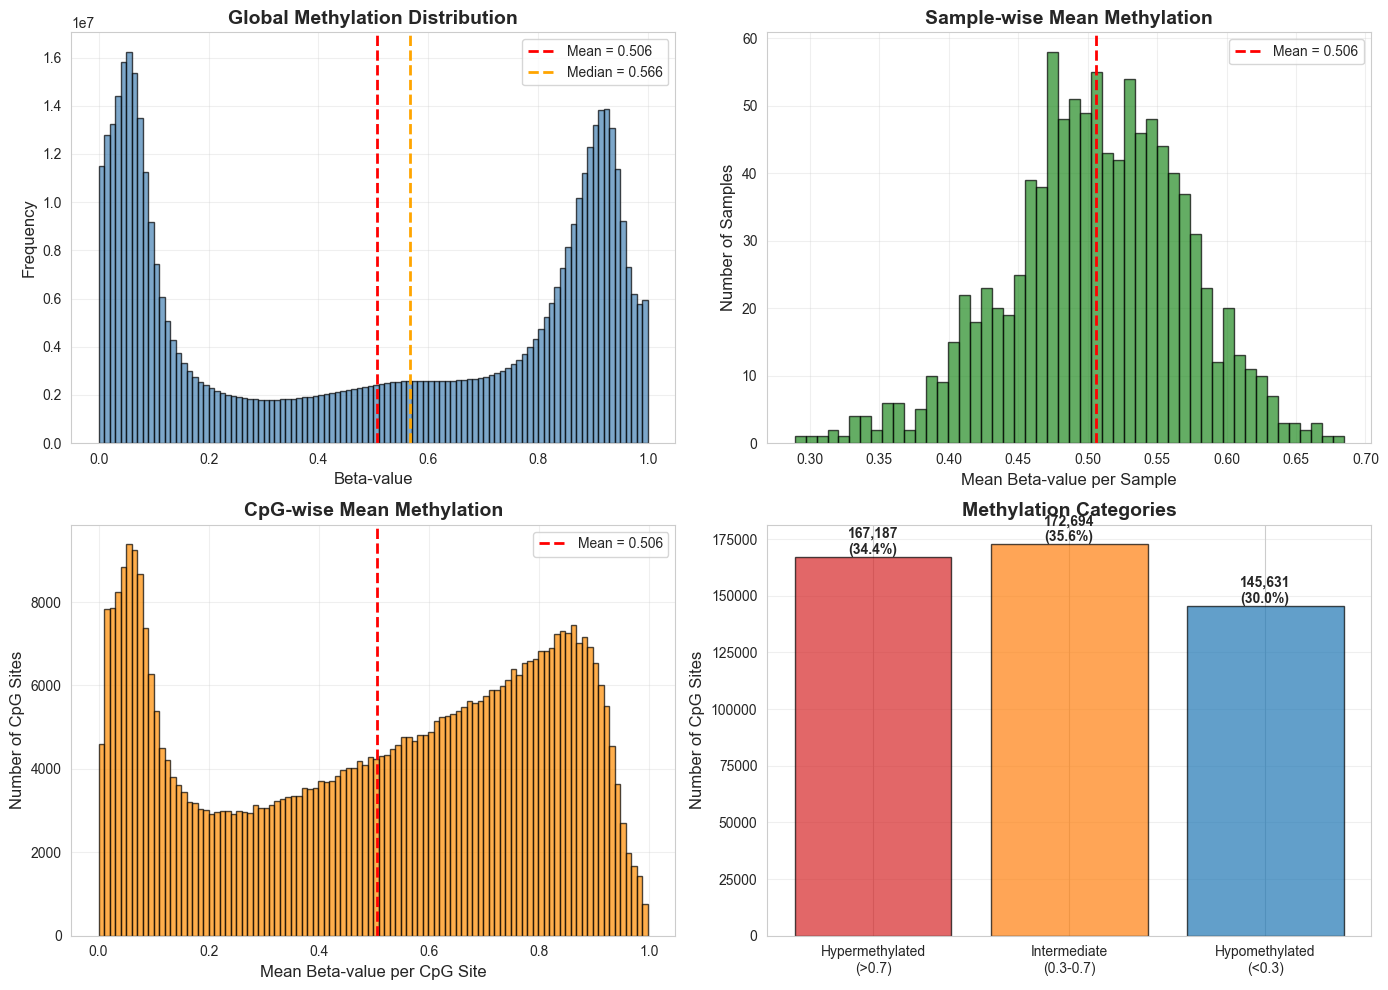


Methylation Summary:
  Hypermethylated CpGs (>0.7): 167,187 (34.4%)
  Intermediate CpGs (0.3-0.7): 172,694 (35.6%)
  Hypomethylated CpGs (<0.3): 145,631 (30.0%)


In [22]:
# Create comprehensive methylation distribution figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Global methylation distribution
all_values = df_methylation.values.flatten()
all_values_clean = all_values[~np.isnan(all_values)]

axes[0, 0].hist(all_values_clean, bins=100, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.3f}')
axes[0, 0].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median = {median_val:.3f}')
axes[0, 0].set_xlabel('Beta-value', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Global Methylation Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Per-sample mean methylation
sample_means = df_methylation.mean(axis=0)
axes[0, 1].hist(sample_means, bins=50, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(sample_means.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean = {sample_means.mean():.3f}')
axes[0, 1].set_xlabel('Mean Beta-value per Sample', fontsize=12)
axes[0, 1].set_ylabel('Number of Samples', fontsize=12)
axes[0, 1].set_title('Sample-wise Mean Methylation', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Per-CpG mean methylation
cpg_means = df_methylation.mean(axis=1)
axes[1, 0].hist(cpg_means, bins=100, color='darkorange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(cpg_means.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean = {cpg_means.mean():.3f}')
axes[1, 0].set_xlabel('Mean Beta-value per CpG Site', fontsize=12)
axes[1, 0].set_ylabel('Number of CpG Sites', fontsize=12)
axes[1, 0].set_title('CpG-wise Mean Methylation', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Methylation categories
cpg_means_clean = cpg_means[~np.isnan(cpg_means)]
hyper = (cpg_means_clean > 0.7).sum()
hypo = (cpg_means_clean < 0.3).sum()
intermediate = ((cpg_means_clean >= 0.3) & (cpg_means_clean <= 0.7)).sum()

categories = ['Hypermethylated\n(>0.7)', 'Intermediate\n(0.3-0.7)', 'Hypomethylated\n(<0.3)']
counts = [hyper, intermediate, hypo]
colors_cat = ['#d62728', '#ff7f0e', '#1f77b4']

bars = axes[1, 1].bar(categories, counts, color=colors_cat, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Number of CpG Sites', fontsize=12)
axes[1, 1].set_title('Methylation Categories', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add percentage labels
total = len(cpg_means_clean)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{count:,}\n({100*count/total:.1f}%)',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(figures_dir / 'GSE68379_methylation_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nMethylation Summary:')
print(f'  Hypermethylated CpGs (>0.7): {hyper:,} ({100*hyper/total:.1f}%)')
print(f'  Intermediate CpGs (0.3-0.7): {intermediate:,} ({100*intermediate/total:.1f}%)')
print(f'  Hypomethylated CpGs (<0.3): {hypo:,} ({100*hypo/total:.1f}%)')

## 5. Sample Metadata Exploration

Primary Site Distribution:
primary site
lung                    198
blood                   177
urogenital_system       115
digestive_system        105
nervous_system           96
aero_digestive_tract     80
skin                     59
breast                   52
bone                     38
kidney                   33
pancreas                 31
soft_tissue              21
thyroid                  17
Name: count, dtype: int64


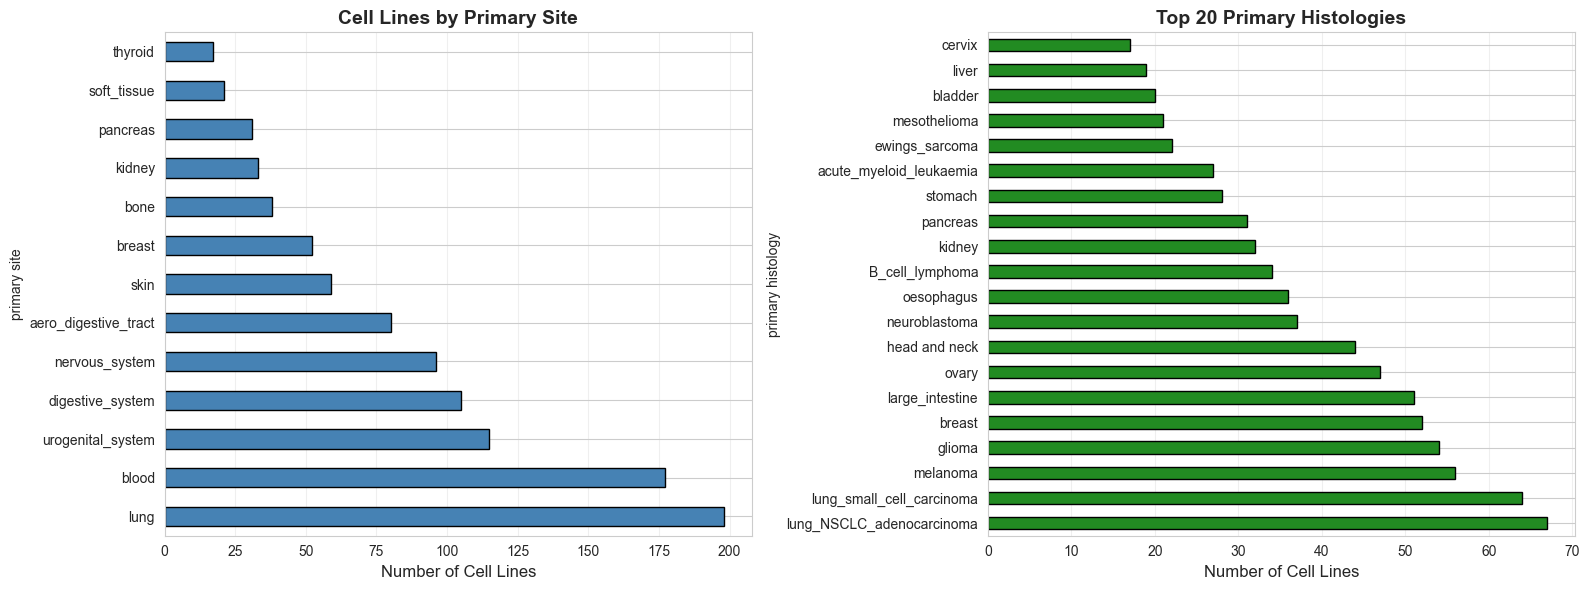


Total unique primary sites: 13
Total unique primary histologies: 56


In [23]:
# Explore primary sites
print('Primary Site Distribution:')
site_counts = df_metadata['primary site'].value_counts()
print(site_counts)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primary sites
site_counts.plot(kind='barh', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Cell Lines', fontsize=12)
axes[0].set_title('Cell Lines by Primary Site', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# Top 20 primary histologies
hist_counts = df_metadata['primary histology'].value_counts().head(20)
hist_counts.plot(kind='barh', ax=axes[1], color='forestgreen', edgecolor='black')
axes[1].set_xlabel('Number of Cell Lines', fontsize=12)
axes[1].set_title('Top 20 Primary Histologies', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(figures_dir / 'GSE68379_sample_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\nTotal unique primary sites: {df_metadata["primary site"].nunique()}')
print(f'Total unique primary histologies: {df_metadata["primary histology"].nunique()}')

## 6. Principal Component Analysis (PCA)

Perform PCA on the most variable CpG sites to identify major sources of variation.

In [24]:
# Select top 10,000 most variable CpG sites for PCA
print('Performing PCA...')
cpg_variance = df_methylation.var(axis=1, skipna=True)
top_variable_cpgs = cpg_variance.nlargest(10000).index

# Subset to top variable CpGs
df_pca_input = df_methylation.loc[top_variable_cpgs, :].T

# Handle any remaining NaN values
df_pca_input = df_pca_input.fillna(df_pca_input.mean())

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca_input)

# Perform PCA
pca = PCA(n_components=20)
pca_result = pca.fit_transform(X_scaled)

# Create PCA dataframe
df_pca = pd.DataFrame(
    pca_result[:, :10],
    columns=[f'PC{i+1}' for i in range(10)],
    index=df_pca_input.index
)

# Add metadata
df_pca = df_pca.join(df_metadata[['primary site', 'primary histology']])

print(f'PCA complete on {len(top_variable_cpgs):,} most variable CpG sites')
print(f'Variance explained by first 10 PCs: {pca.explained_variance_ratio_[:10].sum():.2%}')
print(f'\nVariance by component:')
for i in range(10):
    print(f'  PC{i+1}: {pca.explained_variance_ratio_[i]:.2%}')

Performing PCA...
PCA complete on 10,000 most variable CpG sites
Variance explained by first 10 PCs: 51.44%

Variance by component:
  PC1: 22.75%
  PC2: 8.87%
  PC3: 5.38%
  PC4: 4.43%
  PC5: 3.15%
  PC6: 1.72%
  PC7: 1.60%
  PC8: 1.40%
  PC9: 1.26%
  PC10: 0.86%


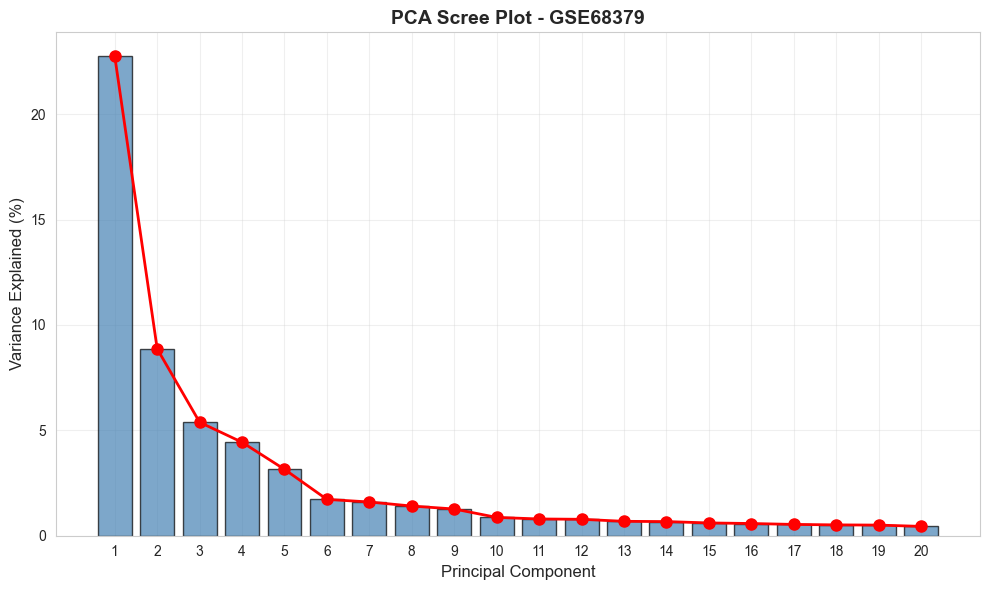

PC1 explains 22.75% of variance
PC2 explains 8.87% of variance
PC1 + PC2 explain 31.62% of total variance


In [25]:
# Scree plot
fig, ax = plt.subplots(figsize=(10, 6))

pcs = range(1, 21)
variance_explained = pca.explained_variance_ratio_ * 100

ax.bar(pcs, variance_explained, color='steelblue', alpha=0.7, edgecolor='black')
ax.plot(pcs, variance_explained, 'ro-', linewidth=2, markersize=8)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Variance Explained (%)', fontsize=12)
ax.set_title('PCA Scree Plot - GSE68379', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(pcs)

plt.tight_layout()
plt.savefig(figures_dir / 'GSE68379_PCA_scree.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'PC1 explains {pca.explained_variance_ratio_[0]:.2%} of variance')
print(f'PC2 explains {pca.explained_variance_ratio_[1]:.2%} of variance')
print(f'PC1 + PC2 explain {pca.explained_variance_ratio_[:2].sum():.2%} of total variance')

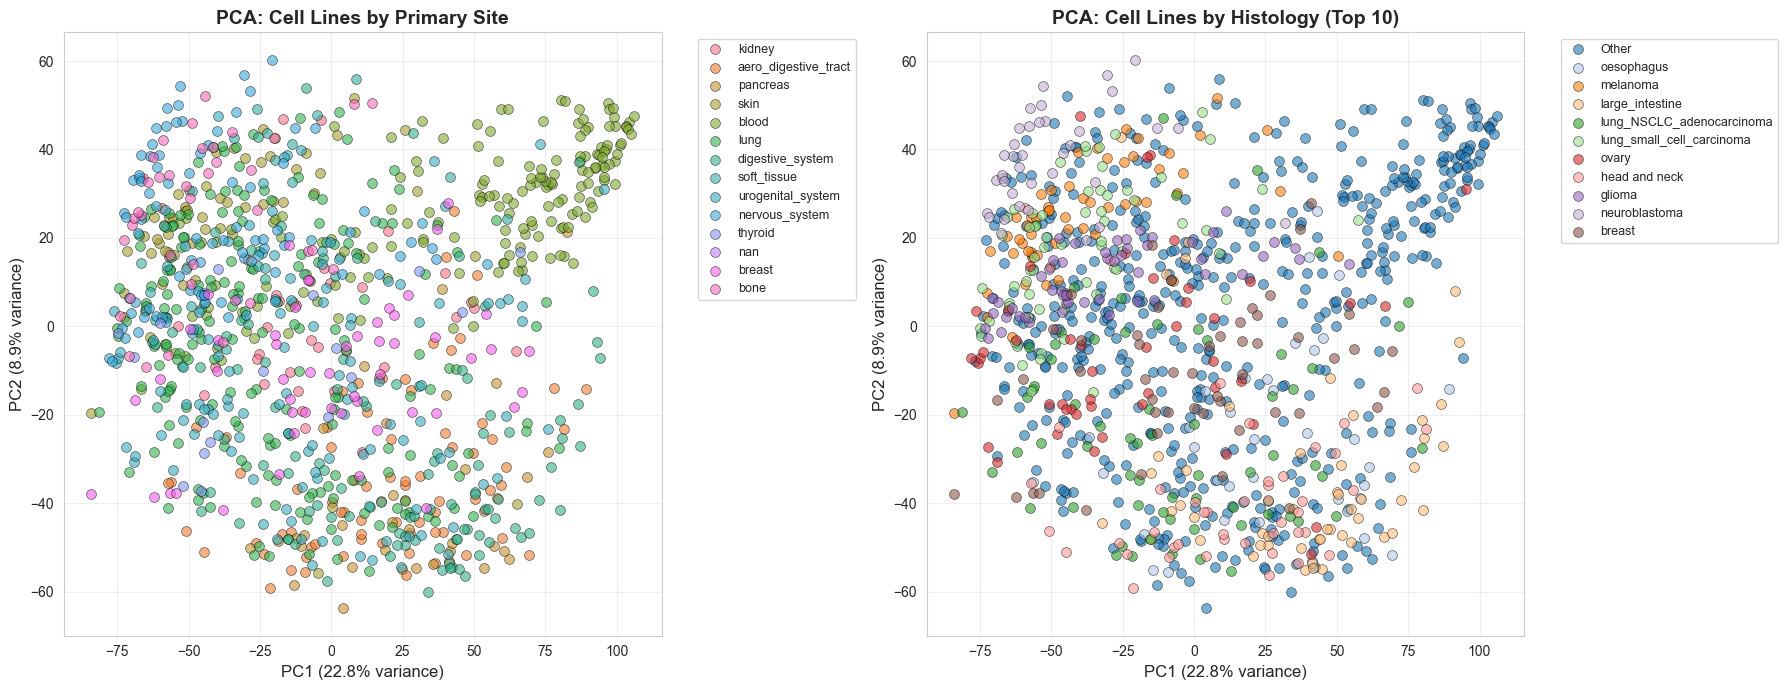

In [26]:
# PCA scatter plots colored by primary site and histology
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by primary site
sites = df_pca['primary site'].unique()
colors_site = sns.color_palette("husl", n_colors=len(sites))
site_color_map = dict(zip(sites, colors_site))

for site in sites:
    mask = df_pca['primary site'] == site
    axes[0].scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        c=[site_color_map[site]],
        label=site,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[0].set_title('PCA: Cell Lines by Primary Site', fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot 2: Colored by top 10 most common histologies
top_histologies = df_metadata['primary histology'].value_counts().head(10).index
df_pca['histology_group'] = df_pca['primary histology'].apply(
    lambda x: x if x in top_histologies else 'Other'
)

hist_groups = df_pca['histology_group'].unique()
colors_hist = sns.color_palette("tab20", n_colors=len(hist_groups))
hist_color_map = dict(zip(hist_groups, colors_hist))

for hist in hist_groups:
    mask = df_pca['histology_group'] == hist
    axes[1].scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        c=[hist_color_map[hist]],
        label=hist,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
axes[1].set_title('PCA: Cell Lines by Histology (Top 10)', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(figures_dir / 'GSE68379_PCA_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

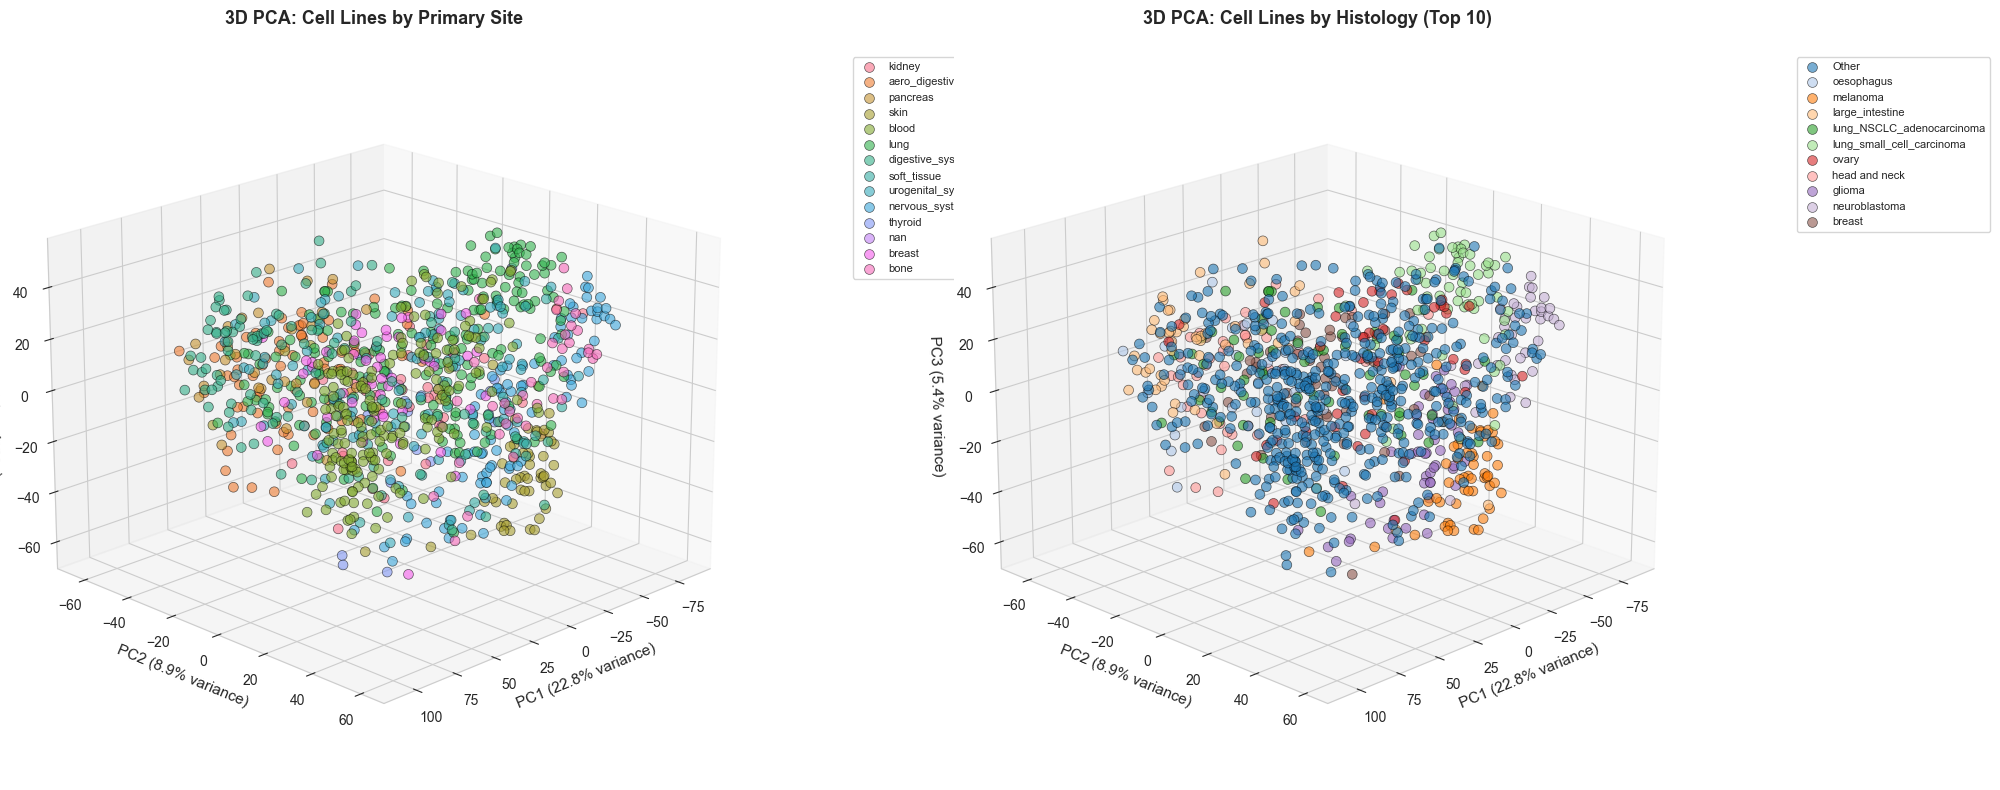


3D PCA Analysis:
  PC1 + PC2 + PC3 explain 37.00% of total variance
  PC3 adds 5.38% additional variance beyond PC1+PC2
  3D visualization reveals additional structure in the methylation data


In [27]:
# 3D PCA scatter plots using PC1, PC2, and PC3
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 8))

# Plot 1: Colored by primary site
ax1 = fig.add_subplot(121, projection='3d')

for site in sites:
    mask = df_pca['primary site'] == site
    ax1.scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        df_pca.loc[mask, 'PC3'],
        c=[site_color_map[site]],
        label=site,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=11)
ax1.set_title('3D PCA: Cell Lines by Primary Site', fontsize=13, fontweight='bold', pad=20)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.view_init(elev=20, azim=45)

# Plot 2: Colored by top 10 most common histologies
ax2 = fig.add_subplot(122, projection='3d')

for hist in hist_groups:
    mask = df_pca['histology_group'] == hist
    ax2.scatter(
        df_pca.loc[mask, 'PC1'],
        df_pca.loc[mask, 'PC2'],
        df_pca.loc[mask, 'PC3'],
        c=[hist_color_map[hist]],
        label=hist,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)', fontsize=11)
ax2.set_title('3D PCA: Cell Lines by Histology (Top 10)', fontsize=13, fontweight='bold', pad=20)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig(figures_dir / 'GSE68379_PCA_3D_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(f'\n3D PCA Analysis:')
print(f'  PC1 + PC2 + PC3 explain {pca.explained_variance_ratio_[:3].sum():.2%} of total variance')
print(f'  PC3 adds {pca.explained_variance_ratio_[2]:.2%} additional variance beyond PC1+PC2')
print(f'  3D visualization reveals additional structure in the methylation data')

## 7. Hierarchical Clustering

Perform hierarchical clustering on a subset of the most variable CpG sites.

In [28]:
# Select subset for clustering (top 1000 most variable CpGs, all samples)
print('Performing hierarchical clustering...')
top_var_for_clustering = cpg_variance.nlargest(1000).index
df_cluster = df_methylation.loc[top_var_for_clustering, :]

# Fill NaN with row means
df_cluster = df_cluster.T.fillna(df_cluster.mean(axis=1)).T

# Z-score normalization
df_cluster_norm = (df_cluster - df_cluster.mean(axis=1).values.reshape(-1, 1)) / df_cluster.std(axis=1).values.reshape(-1, 1)

print(f'Clustering matrix shape: {df_cluster_norm.shape}')
print(f'  CpG sites: {df_cluster_norm.shape[0]}')
print(f'  Samples: {df_cluster_norm.shape[1]}')

Performing hierarchical clustering...
Clustering matrix shape: (1000, 1028)
  CpG sites: 1000
  Samples: 1028


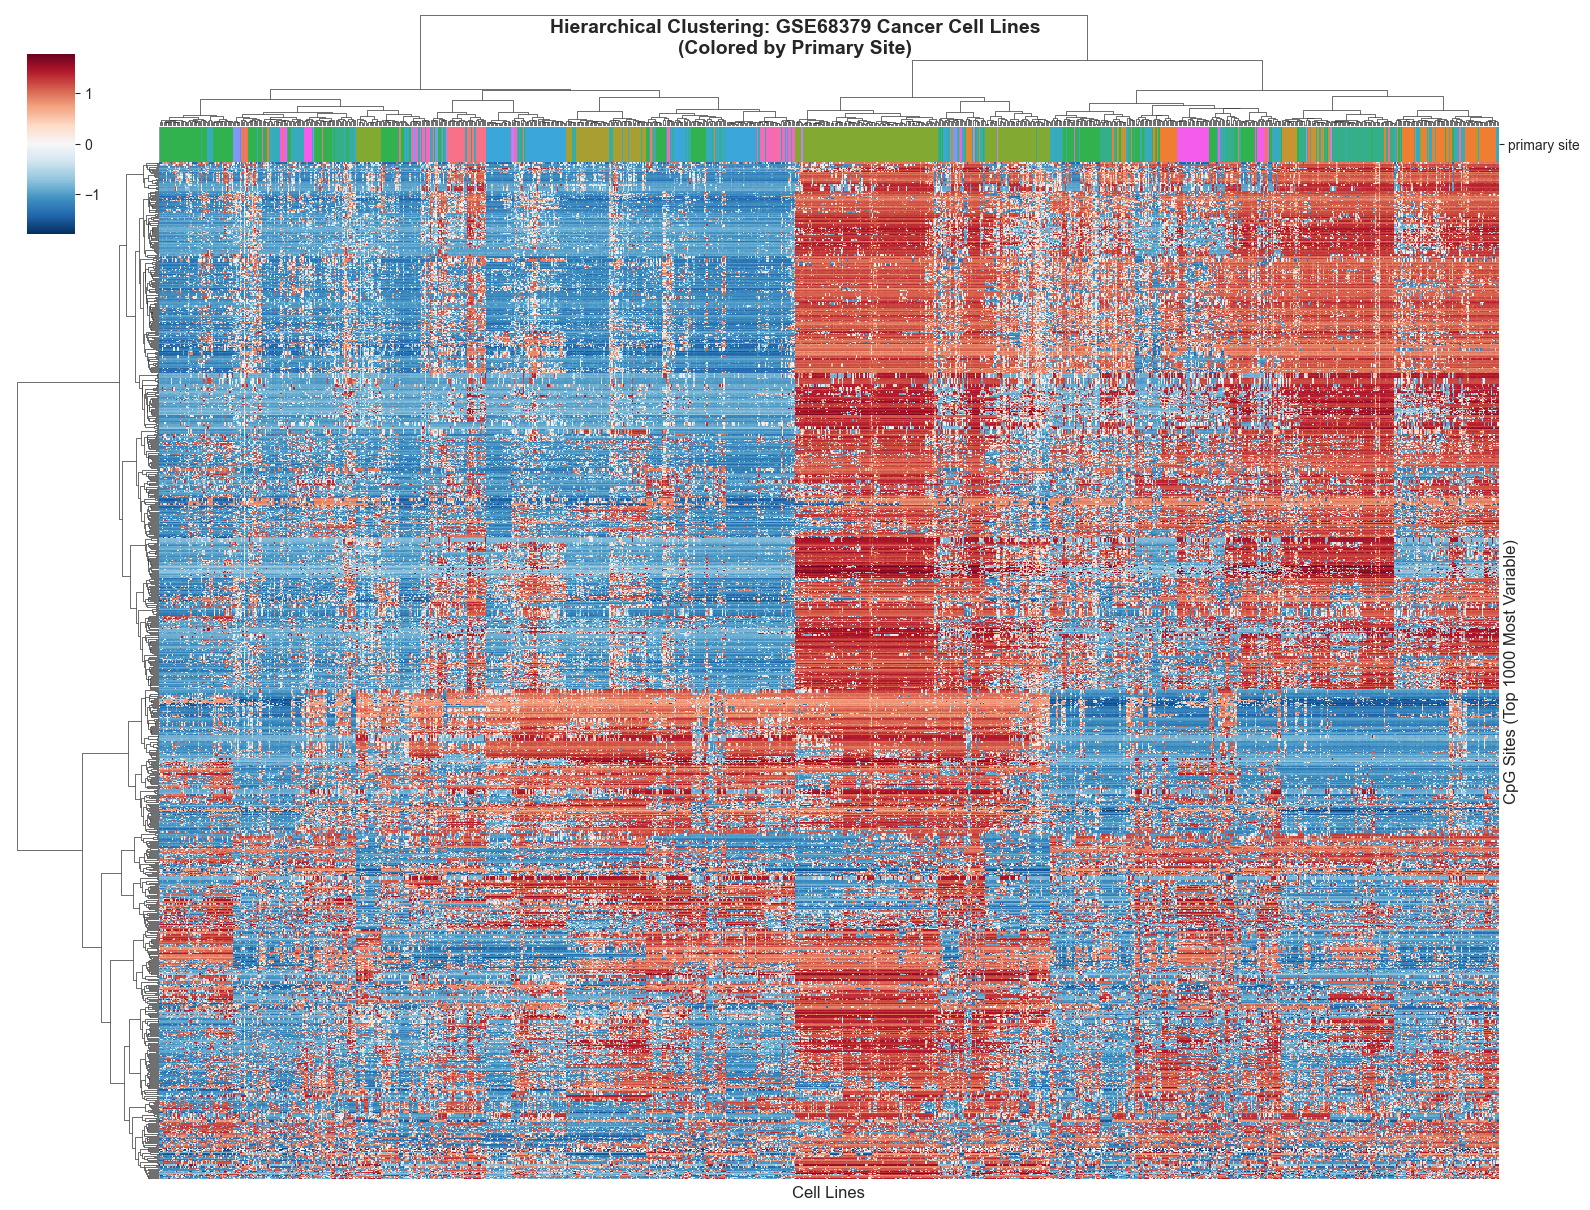

Hierarchical clustering complete
Color bar represents primary site of cell lines


In [29]:
# Create sample annotation colors for primary site
sample_sites = df_metadata.loc[df_cluster_norm.columns, 'primary site']
unique_sites = sample_sites.unique()
site_colors = sns.color_palette("husl", n_colors=len(unique_sites))
site_lut = dict(zip(unique_sites, site_colors))
sample_color_bar = sample_sites.map(site_lut)

# Create clustermap
g = sns.clustermap(
    df_cluster_norm,
    cmap='RdBu_r',
    center=0,
    col_colors=sample_color_bar,
    figsize=(16, 12),
    dendrogram_ratio=0.1,
    cbar_pos=(0.02, 0.8, 0.03, 0.15),
    xticklabels=False,
    yticklabels=False,
    method='ward',
    metric='euclidean'
)

g.ax_heatmap.set_xlabel('Cell Lines', fontsize=12)
g.ax_heatmap.set_ylabel('CpG Sites (Top 1000 Most Variable)', fontsize=12)
g.fig.suptitle('Hierarchical Clustering: GSE68379 Cancer Cell Lines\n(Colored by Primary Site)', 
               fontsize=14, fontweight='bold', y=0.98)

plt.savefig(figures_dir / 'GSE68379_hierarchical_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

print('Hierarchical clustering complete')
print('Color bar represents primary site of cell lines')

## 8. Summary and Key Findings

In [30]:
print('=' * 80)
print('SUMMARY: GSE68379 Cancer Cell Line Pharmacoepigenomics')
print('=' * 80)

print(f'\nDataset Dimensions:')
print(f'  CpG sites analyzed: {df_methylation.shape[0]:,}')
print(f'  Cell lines with metadata: {df_methylation.shape[1]:,}')
print(f'  Primary sites represented: {df_metadata["primary site"].nunique()}')
print(f'  Cancer histologies: {df_metadata["primary histology"].nunique()}')

print(f'\nMethylation Characteristics:')
print(f'  Global mean beta-value: {mean_val:.4f}')
print(f'  Global median beta-value: {median_val:.4f}')
print(f'  Distribution: Bimodal (hypomethylated and hypermethylated peaks)')
print(f'  Hypermethylated CpGs (>0.7): {100*hyper/total:.1f}%')
print(f'  Hypomethylated CpGs (<0.3): {100*hypo/total:.1f}%')

print(f'\nPrincipal Component Analysis:')
print(f'  PC1 variance explained: {pca.explained_variance_ratio_[0]:.2%}')
print(f'  PC2 variance explained: {pca.explained_variance_ratio_[1]:.2%}')
print(f'  First 10 PCs capture: {pca.explained_variance_ratio_[:10].sum():.2%} of variance')

print(f'\nTop 5 Primary Sites:')
for site, count in site_counts.head(5).items():
    print(f'  {site}: {count} cell lines ({100*count/len(df_metadata):.1f}%)')

print(f'\nTop 5 Cancer Histologies:')
for hist, count in df_metadata["primary histology"].value_counts().head(5).items():
    print(f'  {hist}: {count} cell lines ({100*count/len(df_metadata):.1f}%)')

print(f'\nData Quality:')
print(f'  Missing values: {df_methylation.isnull().sum().sum():,} ({100*df_methylation.isnull().sum().sum()/df_methylation.size:.4f}%)')
print(f'  Beta-value range validation: PASSED' if (min_val >= 0 and max_val <= 1) else '  Beta-value range validation: WARNING')

print('\n' + '=' * 80)
print('Analysis complete - All figures saved to:', figures_dir.resolve())
print('=' * 80)

SUMMARY: GSE68379 Cancer Cell Line Pharmacoepigenomics

Dataset Dimensions:
  CpG sites analyzed: 485,512
  Cell lines with metadata: 1,028
  Primary sites represented: 13
  Cancer histologies: 56

Methylation Characteristics:
  Global mean beta-value: 0.5060
  Global median beta-value: 0.5662
  Distribution: Bimodal (hypomethylated and hypermethylated peaks)
  Hypermethylated CpGs (>0.7): 34.4%
  Hypomethylated CpGs (<0.3): 30.0%

Principal Component Analysis:
  PC1 variance explained: 22.75%
  PC2 variance explained: 8.87%
  First 10 PCs capture: 51.44% of variance

Top 5 Primary Sites:
  lung: 198 cell lines (19.3%)
  blood: 177 cell lines (17.2%)
  urogenital_system: 115 cell lines (11.2%)
  digestive_system: 105 cell lines (10.2%)
  nervous_system: 96 cell lines (9.3%)

Top 5 Cancer Histologies:
  lung_NSCLC_adenocarcinoma: 67 cell lines (6.5%)
  lung_small_cell_carcinoma: 64 cell lines (6.2%)
  melanoma: 56 cell lines (5.4%)
  glioma: 54 cell lines (5.3%)
  breast: 52 cell lines 

## 9. Save Processed Data (Optional)

Save filtered methylation matrix and PCA results for downstream analysis.

In [31]:
# Optionally save filtered data for downstream analysis
print('Saving processed data...')

# Save PCA results
df_pca.to_csv(processed_dir / 'GSE68379_PCA_results.csv')
print(f'Saved: PCA results ({processed_dir / "GSE68379_PCA_results.csv"})')

# Save top variable CpGs for reference
pd.DataFrame({'CpG_ID': top_variable_cpgs, 'Variance': cpg_variance[top_variable_cpgs].values}).to_csv(
    processed_dir / 'GSE68379_top10k_variable_CpGs.csv', index=False
)
print(f'Saved: Top 10,000 variable CpGs ({processed_dir / "GSE68379_top10k_variable_CpGs.csv"})')

print('\nAll processed data saved successfully!')

Saving processed data...
Saved: PCA results (..\data\processed\GSE68379_PCA_results.csv)
Saved: Top 10,000 variable CpGs (..\data\processed\GSE68379_top10k_variable_CpGs.csv)

All processed data saved successfully!
